## Loại bỏ đầu ra, phân cụm dữ liệu bằng KMeans

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.metrics import (
    adjusted_rand_score,
    fowlkes_mallows_score,
    normalized_mutual_info_score,
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)


df = pd.read_csv("../../data/data_processed/data_processed.csv")
labels_true = df["NSP"]
X = df.drop(columns=["NSP"])

# Chuẩn hóa 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto', init='random')
clusters = kmeans.fit_predict(X_scaled)


#Độ đo có nhãn (supervised)
ari = adjusted_rand_score(labels_true, clusters)
fmi = fowlkes_mallows_score(labels_true, clusters)
nmi = normalized_mutual_info_score(labels_true, clusters)

#Độ đo không nhãn (unsupervised)
silhouette = silhouette_score(X_scaled, clusters)
dbi = davies_bouldin_score(X_scaled, clusters)
chi = calinski_harabasz_score(X_scaled, clusters)

print("Supervised Metrics")
print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Fowlkes-Mallows Index (FMI): {fmi}")
print(f"Normalized Mutual Information (NMI): {nmi}")

print("Unsupervised Metrics")
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {dbi}")
print(f"Calinski-Harabasz Index: {chi}")


Supervised Metrics
Adjusted Rand Index (ARI): 0.1917095852257659
Fowlkes-Mallows Index (FMI): 0.6132853054854149
Normalized Mutual Information (NMI): 0.19733537003265947
Unsupervised Metrics
Silhouette Score: 0.16442446938976854
Davies-Bouldin Index: 1.8757317417173855
Calinski-Harabasz Index: 399.33084558936224


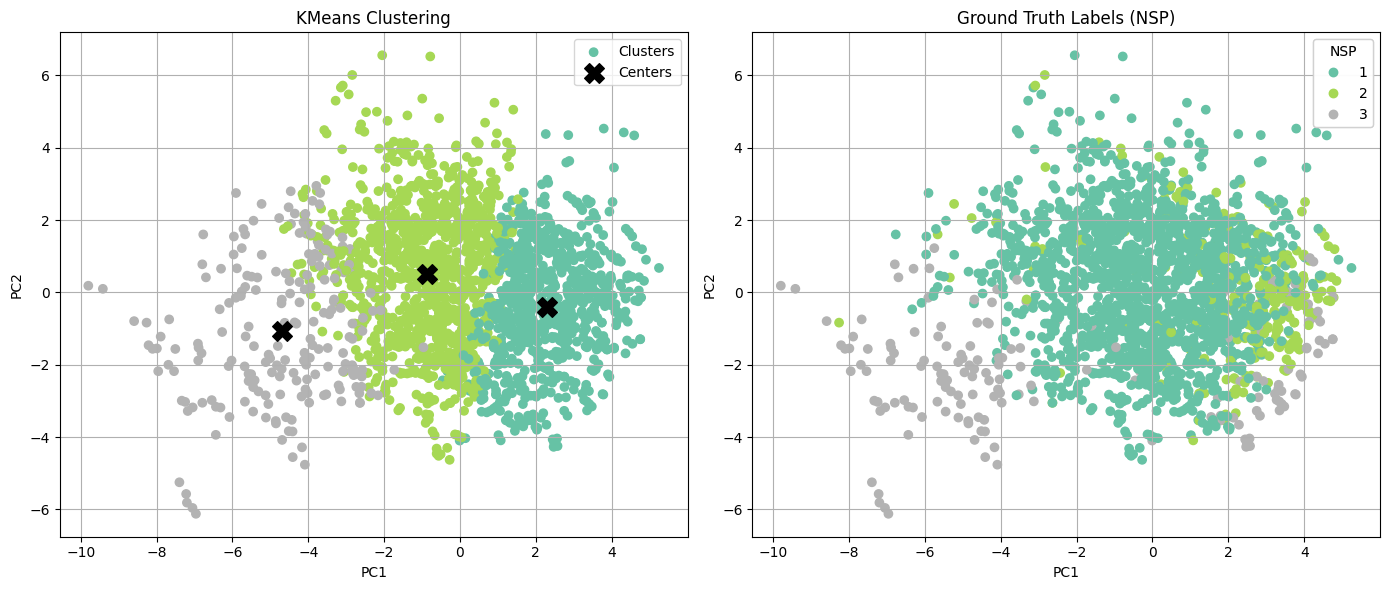

In [17]:
#Giảm xuống 2 chiều để trực quan hoá
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
centers_pca = pca.transform(kmeans.cluster_centers_)


fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Đồ thị 1: Clustering
axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='Set2', label='Clusters')
axs[0].scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', marker='X', s=200, label='Centers')
axs[0].set_title("KMeans Clustering")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")
axs[0].legend()
axs[0].grid(True)

# Đồ thị 2: Ground truth labels
scatter = axs[1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_true, cmap='Set2')
axs[1].set_title("Ground Truth Labels (NSP)")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")
legend1 = axs[1].legend(*scatter.legend_elements(), title="NSP")
axs[1].add_artist(legend1)
axs[1].grid(True)

plt.tight_layout()
plt.show()


k = 2 --> Silhouette Score = 0.2020
k = 3 --> Silhouette Score = 0.1644
k = 4 --> Silhouette Score = 0.1591
k = 5 --> Silhouette Score = 0.1439
k = 6 --> Silhouette Score = 0.1557
k = 7 --> Silhouette Score = 0.1552
k = 8 --> Silhouette Score = 0.1501
k = 9 --> Silhouette Score = 0.1570
k = 10 --> Silhouette Score = 0.1262


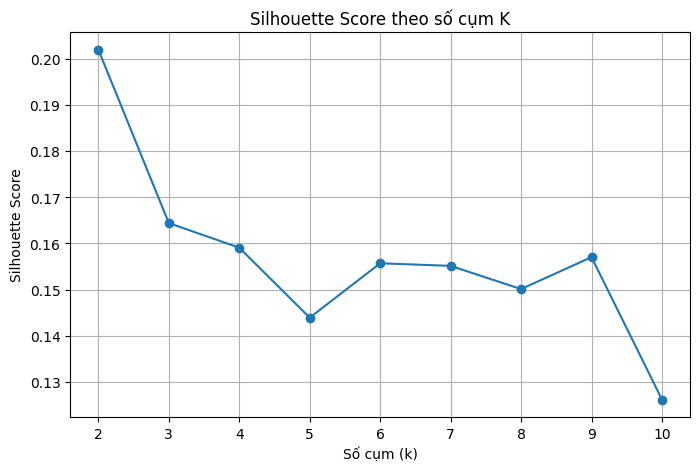

In [ ]:
# Tính silhouette score cho từng số cụm
silhouette_scores = []

ks = range(2, 11)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', init='random')
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"k = {k} --> Silhouette Score = {score:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(ks, silhouette_scores, marker='o')
plt.title("Silhouette Score theo số cụm K")
plt.xlabel("Số cụm (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [15]:
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score, normalized_mutual_info_score


def kmeans_init_centroids(X, k):
    return X[np.random.choice(X.shape[0], k, replace=False)]

def kmeans_assign_labels(X, centroids):
    D = cdist(X, centroids)
    return np.argmin(D, axis = 1)

def has_converged(centroids, new_centroids):
    return (set([tuple(a) for a in centroids]) ==
            set([tuple(a) for a in new_centroids]))

def kmeans_update_centroids(X, labels, K):
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        Xk = X[labels == k, :]
        centroids[k,:] = np.mean(Xk, axis = 0)
    return centroids

def kmeans(X, K):
    centroids = [kmeans_init_centroids(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centroids[-1]))
        new_centroids = kmeans_update_centroids(X, labels[-1], K)
        if has_converged(centroids[-1], new_centroids):
            break
        centroids.append(new_centroids)
        it += 1
    return (centroids, labels, it)


K = 3
centroids, labels, it = kmeans(X_scaled, K)
final_labels = labels[-1]

# Đánh giá
ari = adjusted_rand_score(labels_true, final_labels)
fmi = fowlkes_mallows_score(labels_true, final_labels)
nmi = normalized_mutual_info_score(labels_true, final_labels)

print('Centers found by our algorithm:\n', centroids[-1])
print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Fowlkes-Mallows Index (FMI): {fmi}")
print(f"Normalized Mutual Information (NMI): {nmi}")

Centers found by our algorithm:
 [[ 0.33955743 -0.29676742 -0.14255615 -0.2060849  -0.57091041 -0.0574756
  -0.26494957  0.36362134 -0.66355505  0.49035717 -0.07876955 -0.85557485
   0.88062693 -0.40670518 -0.68205726 -0.31706787  0.27434011  0.41415671
   0.32390087 -0.53862556 -0.16600853]
 [-0.23242563  0.39885104 -0.01423181  0.09314452  0.23761993 -0.0574756
  -0.20464985 -0.42199097  0.40652057 -0.3965261   0.2693829   0.64906762
  -0.68012243  0.28869051  0.52006446  0.27111304  0.05947827 -0.01945203
   0.0113002   0.18649215  0.35734309]
 [-0.55409459 -0.38619652  0.7299174   0.54942091  1.6128429   0.52439646
   2.14915921  0.1764924   1.29486117 -0.52940649 -0.8297711   1.11402544
  -1.09305377  0.61784544  0.87638107  0.27686224 -1.5474033  -1.85016047
  -1.56488116  1.6892697  -0.81303841]]
Adjusted Rand Index (ARI): 0.11924628646423831
Fowlkes-Mallows Index (FMI): 0.5733593461202724
Normalized Mutual Information (NMI): 0.1727400351365416


## Nhận xét:
**Mối quan hệ giữa các mẫu dữ liệu đầu vào trong các cụm:**
- Silhouette Score = 0.16 (thấp): Cụm không thực sự phân biệt rõ, có sự chồng lấn giữa các cụm.
**Quan hệ giữa các đầu ra tương ứng trong các cụm:**
- ARI = 0.19: Cho thấy mối liên hệ kém giữa nhãn thật (NSP) và kết quả phân cụm. Các cụm chỉ phản ánh một phần thông tin nhãn NSP, không khớp tốt với nhãn thực.